In [68]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

import open3d as o3d
import torch
import tqdm
from diffusers import StableDiffusionPipeline

from IPython.display import Image


In [69]:
base_path = Path('../Dataset/')
metadata = pd.read_csv(base_path/'metadata_modelnet40.csv')
dataset_dir = base_path/'ModelNet40'

In [70]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ('Not a valid OFF header')
    n_verts, n_faces, __ = tuple(
        [int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')]
             for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:]
             for i_face in range(n_faces)]
    return verts, faces


# read in data
sample_label = 'airplane'
with open(f'{dataset_dir}/{sample_label}/train/{sample_label}_0001.off', 'r') as f:
    verts, faces = read_off(f)

In [71]:
# generate texture image
pipe = StableDiffusionPipeline.from_pretrained('../SavedPretrainedModel/texture_diffusion', torch_dtype=torch.float32)
pipe.enable_attention_slicing()
# pipe = StableDiffusionPipeline.from_pretrained('dream-textures/texture-diffusion', torch_dtype=torch.float32)
# pipe.save_pretrained('../SavedPretrainedModel/texture_diffusion')
# pipe = pipe.to('cuda')

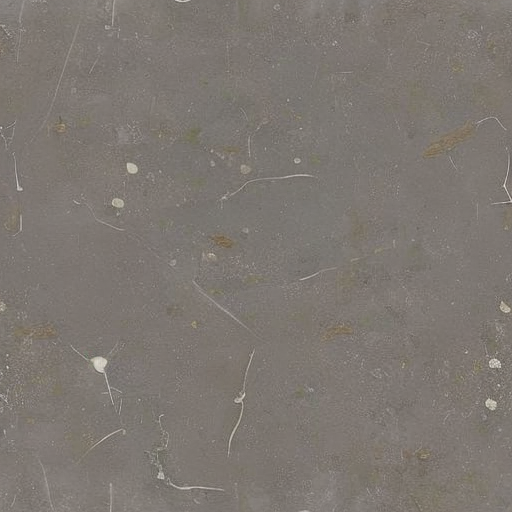

In [73]:
# display brick texture
prompt = f'pbr bright white marble'

image_path = '../Texture/' + prompt.replace(' ', '_') + '.png'
if not os.path.exists(image_path):
    images = pipe(prompt).images
    images[0].save(image_path)
    
Image(filename=image_path)


In [76]:
labels = pd.read_csv(base_path/'metadata_modelnet40.csv')['class'].unique().tolist()

In [ ]:
for label in labels:
    prompt = f'pbr {label}'
    image_path = '../Texture/' + prompt.replace(' ', '_') + '.png'
    if os.path.exists(image_path):
        continue
    print(prompt)
    images = pipe(prompt).images
    images[0].save(image_path)
    Image(filename=image_path)


In [63]:
def generate_texture_coords(verts, faces, texture_file):
    texture = cv2.imread(texture_file, cv2.COLOR_BGR2RGB)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
    triangles_uv = []
    for face in faces:
        v1, v2, v3 = verts[face[0]], verts[face[1]], verts[face[2]]
        uv1 = [v1[0] / texture.shape[1], v1[1] / texture.shape[0]]
        uv2 = [v2[0] / texture.shape[1], v2[1] / texture.shape[0]]
        uv3 = [v3[0] / texture.shape[1], v3[1] / texture.shape[0]]
        triangles_uv.extend([uv1, uv2, uv3])
        
    triangles_uv = np.array(triangles_uv)

    return texture, triangles_uv


prompt = f'pbr {sample_label}'
image_path = '../Texture/' + prompt.replace(' ', '_') + '.png'
# image_path = r'..\Texture\pbr_brick_wall.png'
texture, triangles_uv = generate_texture_coords(verts, faces, image_path)
# normalize the texture coordinates to the range [0, 1]
triangles_uv = (triangles_uv - np.min(triangles_uv, axis=0)) / (np.max(triangles_uv, axis=0) - np.min(triangles_uv, axis=0))

In [66]:
m = o3d.geometry.TriangleMesh(o3d.open3d.utility.Vector3dVector(verts),
                              o3d.open3d.utility.Vector3iVector(faces))
m.compute_vertex_normals()
m.triangle_uvs = o3d.open3d.utility.Vector2dVector(triangles_uv)
m.triangle_material_ids = o3d.utility.IntVector([0]*len(faces))
m.textures = [o3d.geometry.Image(texture)]

o3d.visualization.draw_geometries([m])